### U-net with simple Resnet Blocks
#### update log
1. Correct the errors to in function iou_metric,  use "my_iou_metric" to moniter the training
2. Use image size 101 x 101, no resizing
3. Last layer dropout reduced by half
4. replace conv2D with 2 basic resnet blocks in each level of U-net
5.  Use faster rle_encode (> 10 times fater than RLenc ) from (https://www.kaggle.com/lpachuong/apply-crf-unet-bn-diceloss)
6. set  random_state= 1234 

Reference kernels:

https://www.kaggle.com/phoenigs/u-net-dropout-augmentation-stratification

https://www.kaggle.com/tgibbons/u-net-without-resizing-images

https://www.kaggle.com/lpachuong/apply-crf-unet-bn-diceloss

The results seems not reproducible,  sometimes good (best around IOU0.79 ), sometimes  not as good!
Any suggestions to improve the results?

In [1]:
import os
import sys
import random

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
plt.style.use('seaborn-white')
import seaborn as sns
sns.set_style("white")

%matplotlib inline

# import cv2
from sklearn.model_selection import train_test_split

from tqdm import tqdm_notebook, tnrange
from itertools import chain
from skimage.io import imread, imshow, concatenate_images
from skimage.transform import resize
from skimage.morphology import label

from keras.models import Model, load_model
from keras.layers import Input,Dropout,BatchNormalization,Activation,Add, LeakyReLU
from keras.layers.core import Lambda
from keras.layers.convolutional import Conv2D, Conv2DTranspose
from keras.layers.pooling import MaxPooling2D
from keras.layers.merge import concatenate
from keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from keras import backend as K

import tensorflow as tf

import sys
import warnings 
if not sys.warnoptions:
    warnings.simplefilter("ignore")
    
from keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img#,save_img
import sys
sys.path.insert(0, './utils/')

from cyclelr_callback import *

Using TensorFlow backend.


ModuleNotFoundError: No module named 'cyclelr_callback'

In [39]:
# Set some parameters
im_width = 101
im_height = 101
im_chan = 1
basicpath = './input/'
path_train = basicpath + 'train/'
path_test = basicpath + 'test/'

path_train_images = path_train + 'images/'
path_train_masks = path_train + 'masks/'
path_test_images = path_test + 'images/'

In [40]:
img_size_ori = 101
img_size_target = 128

def upsample(img):# not used
    if img_size_ori == img_size_target:
        return img
    return resize(img, (img_size_target, img_size_target), mode='constant', preserve_range=True)
    #res = np.zeros((img_size_target, img_size_target), dtype=img.dtype)
    #res[:img_size_ori, :img_size_ori] = img
    #return res
    
def downsample(img):# not used
    if img_size_ori == img_size_target:
        return img
    return resize(img, (img_size_ori, img_size_ori), mode='constant', preserve_range=True)
    #return img[:img_size_ori, :img_size_ori]

In [41]:
# Loading of training/testing ids and depths

train_df = pd.read_csv("./input/train.csv", index_col="id", usecols=[0])
depths_df = pd.read_csv("./input/depths.csv", index_col="id")
train_df = train_df.join(depths_df)
test_df = depths_df[~depths_df.index.isin(train_df.index)]

In [42]:
train_df["images"] = [np.array(load_img("./input/train/images/{}.png".format(idx), grayscale=True)) / 255 for idx in tqdm_notebook(train_df.index)]

In [43]:
train_df["masks"] = [np.array(load_img("./input/train/masks/{}.png".format(idx), grayscale=True)) / 255 for idx in tqdm_notebook(train_df.index)]

In [44]:
train_df["coverage"] = train_df.masks.map(np.sum) / pow(img_size_ori, 2)

def cov_to_class(val):    
    for i in range(0, 11):
        if val * 10 <= i :
            return i
        
train_df["coverage_class"] = train_df.coverage.map(cov_to_class)

In [45]:
# Create train/validation split stratified by salt coverage

ids_train, ids_valid, x_train, x_valid, y_train, y_valid, cov_train, cov_test, depth_train, depth_test = train_test_split(
    train_df.index.values,
    np.array(train_df.images.map(upsample).tolist()).reshape(-1, img_size_target, img_size_target, 1), 
    np.array(train_df.masks.map(upsample).tolist()).reshape(-1, img_size_target, img_size_target, 1), 
    train_df.coverage.values,
    train_df.z.values,
    test_size=0.2, stratify=train_df.coverage_class, random_state= 1234)

In [9]:
def convolution_block(x, filters, size, strides=(1,1), padding='same', activation=True):
    x = Conv2D(filters, size, strides=strides, padding=padding)(x)
    x = BatchNormalization()(x)
    if activation == True:
        x = Activation('relu')(x)
    return x

def residual_block(blockInput, num_filters=16):
    x = Activation('relu')(blockInput)
    x = BatchNormalization()(x)
    x = convolution_block(x, num_filters, (3,3) )
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = convolution_block(x, num_filters, (3,3), activation=False)
    x = Add()([x, blockInput])
    return x

In [21]:
# Build model
def build_model(input_layer, start_neurons, DropoutRatio = 0.5):
    # 128 -> 128/2
    conv1 = Conv2D(start_neurons * 1, (3, 3), activation=None, padding="same")(input_layer)
    conv1 = residual_block(conv1,start_neurons * 1)
    conv1 = residual_block(conv1,start_neurons * 1)
    conv1 = Activation('relu')(conv1)
    pool1 = MaxPooling2D((2, 2))(conv1)
    pool1 = Dropout(DropoutRatio/2)(pool1)

    #   -> 128/4
    conv2 = Conv2D(start_neurons * 2, (3, 3), activation=None, padding="same")(pool1)
    conv2 = residual_block(conv2,start_neurons * 2)
    conv2 = residual_block(conv2,start_neurons * 2)
    conv2 = Activation('relu')(conv2)
    pool2 = MaxPooling2D((2, 2))(conv2)
    pool2 = Dropout(DropoutRatio)(pool2)

    #  -> 128/8
    conv3 = Conv2D(start_neurons * 4, (3, 3), activation=None, padding="same")(pool2)
    conv3 = residual_block(conv3,start_neurons * 4)
    conv3 = residual_block(conv3,start_neurons * 4)
    conv3 = Activation('relu')(conv3)
    pool3 = MaxPooling2D((2, 2))(conv3)
    pool3 = Dropout(DropoutRatio)(pool3)

    #  -> 128/16
    conv4 = Conv2D(start_neurons * 8, (3, 3), activation=None, padding="same")(pool3)
    conv4 = residual_block(conv4,start_neurons * 8)
    conv4 = residual_block(conv4,start_neurons * 8)
    conv4 = Activation('relu')(conv4)
    pool4 = MaxPooling2D((2, 2))(conv4)
    pool4 = Dropout(DropoutRatio)(pool4)

    # Middle
     #   -> 128/16
    convm = Conv2D(start_neurons * 16, (3, 3), activation=None, padding="same")(pool4)
    convm = residual_block(convm,start_neurons * 16)
    convm = residual_block(convm,start_neurons * 16)
    convm = Activation('relu')(convm)
    
    #  -> 128/8
    deconv4 = Conv2DTranspose(start_neurons * 8, (3, 3), strides=(2, 2), padding="same")(convm)
    uconv4 = concatenate([deconv4, conv4])
    uconv4 = Dropout(DropoutRatio)(uconv4)
    
    uconv4 = Conv2D(start_neurons * 8, (3, 3), activation=None, padding="same")(uconv4)
    uconv4 = residual_block(uconv4,start_neurons * 8)
    uconv4 = residual_block(uconv4,start_neurons * 8)
    uconv4 = Activation('relu')(uconv4)
    
    #  -> 128/4
    deconv3 = Conv2DTranspose(start_neurons * 4, (3, 3), strides=(2, 2), padding="same")(uconv4)
    #deconv3 = Conv2DTranspose(start_neurons * 4, (3, 3), strides=(2, 2), padding="valid")(uconv4)
    uconv3 = concatenate([deconv3, conv3])    
    uconv3 = Dropout(DropoutRatio)(uconv3)
    
    uconv3 = Conv2D(start_neurons * 4, (3, 3), activation=None, padding="same")(uconv3)
    uconv3 = residual_block(uconv3,start_neurons * 4)
    uconv3 = residual_block(uconv3,start_neurons * 4)
    uconv3 = Activation('relu')(uconv3)

    #  -> 128/2
    deconv2 = Conv2DTranspose(start_neurons * 2, (3, 3), strides=(2, 2), padding="same")(uconv3)
    uconv2 = concatenate([deconv2, conv2])
        
    uconv2 = Dropout(DropoutRatio)(uconv2)
    uconv2 = Conv2D(start_neurons * 2, (3, 3), activation=None, padding="same")(uconv2)
    uconv2 = residual_block(uconv2,start_neurons * 2)
    uconv2 = residual_block(uconv2,start_neurons * 2)
    uconv2 = Activation('relu')(uconv2)
    
    # 128
    deconv1 = Conv2DTranspose(start_neurons * 1, (3, 3), strides=(2, 2), padding="same")(uconv2)
    #deconv1 = Conv2DTranspose(start_neurons * 1, (3, 3), strides=(2, 2), padding="valid")(uconv2)
    uconv1 = concatenate([deconv1, conv1])
    
    uconv1 = Dropout(DropoutRatio)(uconv1)
    uconv1 = Conv2D(start_neurons * 1, (3, 3), activation=None, padding="same")(uconv1)
    uconv1 = residual_block(uconv1,start_neurons * 1)
    uconv1 = residual_block(uconv1,start_neurons * 1)
    uconv1 = Activation('relu')(uconv1)
    
    uconv1 = Dropout(DropoutRatio/2)(uconv1)
    output_layer = Conv2D(1, (1,1), padding="same", activation="sigmoid")(uconv1)
    
    return output_layer

In [11]:
#Score the model and do a threshold optimization by the best IoU.

# src: https://www.kaggle.com/aglotero/another-iou-metric
def iou_metric(y_true_in, y_pred_in, print_table=False):
    labels = y_true_in
    y_pred = y_pred_in


    true_objects = 2
    pred_objects = 2

    # Jiaxin fin that if all zeros, then, the background is treated as object
    temp1 = np.histogram2d(labels.flatten(), y_pred.flatten(), bins=([0,0.5,1], [0,0.5, 1]))
#     temp1 = np.histogram2d(labels.flatten(), y_pred.flatten(), bins=(true_objects, pred_objects))
    #print(temp1)
    intersection = temp1[0]
    #print("temp2 = ",temp1[1])
    #print(intersection.shape)
   # print(intersection)
    # Compute areas (needed for finding the union between all objects)
    #print(np.histogram(labels, bins = true_objects))
    area_true = np.histogram(labels,bins=[0,0.5,1])[0]
    #print("area_true = ",area_true)
    area_pred = np.histogram(y_pred, bins=[0,0.5,1])[0]
    area_true = np.expand_dims(area_true, -1)
    area_pred = np.expand_dims(area_pred, 0)

    # Compute union
    union = area_true + area_pred - intersection
  
    # Exclude background from the analysis
    intersection = intersection[1:,1:]
    intersection[intersection == 0] = 1e-9
    
    union = union[1:,1:]
    union[union == 0] = 1e-9

    # Compute the intersection over union
    iou = intersection / union

    # Precision helper function
    def precision_at(threshold, iou):
        matches = iou > threshold
        true_positives = np.sum(matches, axis=1) == 1   # Correct objects
        false_positives = np.sum(matches, axis=0) == 0  # Missed objects
        false_negatives = np.sum(matches, axis=1) == 0  # Extra objects
        tp, fp, fn = np.sum(true_positives), np.sum(false_positives), np.sum(false_negatives)
        return tp, fp, fn

    # Loop over IoU thresholds
    prec = []
    if print_table:
        print("Thresh\tTP\tFP\tFN\tPrec.")
    for t in np.arange(0.5, 1.0, 0.05):
        tp, fp, fn = precision_at(t, iou)
        if (tp + fp + fn) > 0:
            p = tp / (tp + fp + fn)
        else:
            p = 0
        if print_table:
            print("{:1.3f}\t{}\t{}\t{}\t{:1.3f}".format(t, tp, fp, fn, p))
        prec.append(p)
    
    if print_table:
        print("AP\t-\t-\t-\t{:1.3f}".format(np.mean(prec)))
    return np.mean(prec)

def iou_metric_batch(y_true_in, y_pred_in):
    y_pred_in = y_pred_in > 0.5 # added by sgx 20180728
    batch_size = y_true_in.shape[0]
    metric = []
    for batch in range(batch_size):
        value = iou_metric(y_true_in[batch], y_pred_in[batch])
        metric.append(value)
    #print("metric = ",metric)
    return np.mean(metric)

def my_iou_metric(label, pred):
    metric_value = tf.py_func(iou_metric_batch, [label, pred], tf.float64)
    return metric_value

In [23]:
import keras.backend as K
from keras.backend.tensorflow_backend import _to_tensor
from keras.losses import binary_crossentropy


def dice_coef_clipped(y_true, y_pred, smooth=1.0):
    y_true_f = K.flatten(K.round(y_true))
    y_pred_f = K.flatten(K.round(y_pred))
    intersection = K.sum(y_true_f * y_pred_f)
    return 100. * (2. * intersection + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth)


def dice_coef(y_true, y_pred, smooth=1.0):
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    return (2. * intersection + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth)


def bootstrapped_crossentropy(y_true, y_pred, bootstrap_type='hard', alpha=0.95):
    target_tensor = y_true
    prediction_tensor = y_pred
    _epsilon = _to_tensor(K.epsilon(), prediction_tensor.dtype.base_dtype)
    prediction_tensor = K.tf.clip_by_value(prediction_tensor, _epsilon, 1 - _epsilon)
    prediction_tensor = K.tf.log(prediction_tensor / (1 - prediction_tensor))

    if bootstrap_type == 'soft':
        bootstrap_target_tensor = alpha * target_tensor + (1.0 - alpha) * K.tf.sigmoid(prediction_tensor)
    else:
        bootstrap_target_tensor = alpha * target_tensor + (1.0 - alpha) * K.tf.cast(
            K.tf.sigmoid(prediction_tensor) > 0.5, K.tf.float32)
    return K.mean(K.tf.nn.sigmoid_cross_entropy_with_logits(
        labels=bootstrap_target_tensor, logits=prediction_tensor))


def online_bootstrapping(y_true, y_pred, pixels=512, threshold=0.5):
    """ Implements nline Bootstrapping crossentropy loss, to train only on hard pixels,
        see  https://arxiv.org/abs/1605.06885 Bridging Category-level and Instance-level Semantic Image Segmentation
        The implementation is a bit different as we use binary crossentropy instead of softmax
        SUPPORTS ONLY MINIBATCH WITH 1 ELEMENT!
    # Arguments
        y_true: A tensor with labels.
        y_pred: A tensor with predicted probabilites.
        pixels: number of hard pixels to keep
        threshold: confidence to use, i.e. if threshold is 0.7, y_true=1, prediction=0.65 then we consider that pixel as hard
    # Returns
        Mean loss value
    """
    y_true = K.flatten(y_true)
    y_pred = K.flatten(y_pred)
    difference = K.abs(y_true - y_pred)

    values, indices = K.tf.nn.top_k(difference, sorted=True, k=pixels)
    min_difference = (1 - threshold)
    y_true = K.tf.gather(K.gather(y_true, indices), K.tf.where(values > min_difference))
    y_pred = K.tf.gather(K.gather(y_pred, indices), K.tf.where(values > min_difference))

    return K.mean(K.binary_crossentropy(y_true, y_pred))


def dice_coef_loss_border(y_true, y_pred):
    return (1 - dice_coef_border(y_true, y_pred)) * 0.05 + 0.95 * dice_coef_loss(y_true, y_pred)

def bce_dice_loss_border(y_true, y_pred):
    return bce_border(y_true, y_pred) * 0.05 + 0.95 * dice_coef_loss(y_true, y_pred)


def dice_coef_border(y_true, y_pred):
    border = get_border_mask((21, 21), y_true)

    border = K.flatten(border)
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    y_true_f = K.tf.gather(y_true_f, K.tf.where(border > 0.5))
    y_pred_f = K.tf.gather(y_pred_f, K.tf.where(border > 0.5))

    return dice_coef(y_true_f, y_pred_f)


def bce_border(y_true, y_pred):
    border = get_border_mask((21, 21), y_true)

    border = K.flatten(border)
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    y_true_f = K.tf.gather(y_true_f, K.tf.where(border > 0.5))
    y_pred_f = K.tf.gather(y_pred_f, K.tf.where(border > 0.5))

    return binary_crossentropy(y_true_f, y_pred_f)


def get_border_mask(pool_size, y_true):
    negative = 1 - y_true
    positive = y_true
    positive = K.pool2d(positive, pool_size=pool_size, padding="same")
    negative = K.pool2d(negative, pool_size=pool_size, padding="same")
    border = positive * negative
    return border


def dice_coef_loss(y_true, y_pred):
    return 1 - dice_coef(y_true, y_pred)


def dice_coef_loss_bce(y_true, y_pred, dice=0.5, bce=0.5, bootstrapping='hard', alpha=1.):
    return bootstrapped_crossentropy(y_true, y_pred, bootstrapping, alpha) * bce + dice_coef_loss(y_true, y_pred) * dice


def make_loss(loss_name):
    if loss_name == 'crossentropy':
        return K.binary_crossentropy
    elif loss_name == 'crossentropy_boot':
        def loss(y, p):
            return bootstrapped_crossentropy(y, p, 'hard', 0.9)
        return loss
    elif loss_name == 'dice':
        return dice_coef_loss
    elif loss_name == 'bce_dice':
        def loss(y, p):
            return dice_coef_loss_bce(y, p, dice=0.8, bce=0.2, bootstrapping='soft', alpha=1)

        return loss
    elif loss_name == 'boot_soft':
        def loss(y, p):
            return dice_coef_loss_bce(y, p, dice=0.8, bce=0.2, bootstrapping='soft', alpha=0.95)

        return loss
    elif loss_name == 'boot_hard':
        def loss(y, p):
            return dice_coef_loss_bce(y, p, dice=0.8, bce=0.2, bootstrapping='hard', alpha=0.95)

        return loss
    elif loss_name == 'online_bootstrapping':
        def loss(y, p):
            return online_bootstrapping(y, p, pixels=512 * 64, threshold=0.7)

        return loss
    elif loss_name == 'dice_coef_loss_border':
        return dice_coef_loss_border
    elif loss_name == 'bce_dice_loss_border':
        return bce_dice_loss_border
    else:
        ValueError("Unknown loss.")

In [24]:
#Data augmentation
x_train2 = np.append(x_train, [np.fliplr(x) for x in x_train], axis=0)
y_train2 = np.append(y_train, [np.fliplr(x) for x in y_train], axis=0)
print(x_train2.shape)
print(y_valid.shape)

(6400, 128, 128, 1)
(800, 128, 128, 1)


In [25]:
# model
input_layer = Input((img_size_target, img_size_target, 1))
# input_layer2 = Input((img_size_target, img_size_target, 1))
output_layer = build_model(input_layer, 16,0.5)

# del model
model = Model(input_layer, output_layer)
model.compile(loss="binary_crossentropy", optimizer="adam", metrics=[my_iou_metric])

model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            (None, 128, 128, 1)  0                                            
__________________________________________________________________________________________________
conv2d_47 (Conv2D)              (None, 128, 128, 16) 160         input_2[0][0]                    
__________________________________________________________________________________________________
activation_46 (Activation)      (None, 128, 128, 16) 0           conv2d_47[0][0]                  
__________________________________________________________________________________________________
batch_normalization_55 (BatchNo (None, 128, 128, 16) 64          activation_46[0][0]              
__________________________________________________________________________________________________
conv2d_48 

In [26]:
clr_triangular = CyclicLR(mode='triangular2', base_lr=0.0001, max_lr=0.006) 
early_stopping = EarlyStopping(monitor='val_my_iou_metric', mode = 'max',patience=20, verbose=1)
model_checkpoint = ModelCheckpoint("./unet_best1.model",monitor='val_my_iou_metric', 
                                   mode = 'max', save_best_only=True, verbose=1)
reduce_lr = ReduceLROnPlateau(monitor='val_my_iou_metric', mode = 'max',factor=0.2, patience=5, min_lr=0.00001, verbose=1)
#reduce_lr = ReduceLROnPlateau(factor=0.2, patience=5, min_lr=0.00001, verbose=1)
#https://github.com/bckenstler/CLR
epochs = 200
batch_size = 32

history = model.fit(x_train2, y_train2,
                    validation_data=[x_valid, y_valid], 
                    epochs=epochs,
                    batch_size=batch_size,
                    callbacks=[early_stopping, model_checkpoint, clr_triangular], 
                    verbose=2)

Train on 6400 samples, validate on 800 samples
Epoch 1/200
 - 67s - loss: 0.4553 - my_iou_metric: 0.1038 - val_loss: 0.4638 - val_my_iou_metric: 0.1141

Epoch 00001: val_my_iou_metric improved from -inf to 0.11413, saving model to ./unet_best1.model
Epoch 2/200
 - 56s - loss: 0.3151 - my_iou_metric: 0.2564 - val_loss: 0.5788 - val_my_iou_metric: 0.2230

Epoch 00002: val_my_iou_metric improved from 0.11413 to 0.22300, saving model to ./unet_best1.model
Epoch 3/200
 - 58s - loss: 0.2668 - my_iou_metric: 0.4053 - val_loss: 0.4495 - val_my_iou_metric: 0.2657

Epoch 00003: val_my_iou_metric improved from 0.22300 to 0.26575, saving model to ./unet_best1.model
Epoch 4/200
 - 59s - loss: 0.2650 - my_iou_metric: 0.4650 - val_loss: 0.3026 - val_my_iou_metric: 0.4848

Epoch 00004: val_my_iou_metric improved from 0.26575 to 0.48475, saving model to ./unet_best1.model
Epoch 5/200
 - 59s - loss: 0.2522 - my_iou_metric: 0.4889 - val_loss: 0.2738 - val_my_iou_metric: 0.5985

Epoch 00005: val_my_iou_me


Epoch 00046: val_my_iou_metric did not improve from 0.75575
Epoch 47/200
 - 55s - loss: 0.1201 - my_iou_metric: 0.7315 - val_loss: 0.1510 - val_my_iou_metric: 0.7422

Epoch 00047: val_my_iou_metric did not improve from 0.75575
Epoch 48/200
 - 56s - loss: 0.1233 - my_iou_metric: 0.7277 - val_loss: 0.1702 - val_my_iou_metric: 0.7324

Epoch 00048: val_my_iou_metric did not improve from 0.75575
Epoch 49/200
 - 56s - loss: 0.1242 - my_iou_metric: 0.7313 - val_loss: 0.1584 - val_my_iou_metric: 0.7260

Epoch 00049: val_my_iou_metric did not improve from 0.75575
Epoch 50/200
 - 56s - loss: 0.1275 - my_iou_metric: 0.7284 - val_loss: 0.1959 - val_my_iou_metric: 0.6964

Epoch 00050: val_my_iou_metric did not improve from 0.75575
Epoch 51/200
 - 57s - loss: 0.1286 - my_iou_metric: 0.7195 - val_loss: 0.1681 - val_my_iou_metric: 0.7153

Epoch 00051: val_my_iou_metric did not improve from 0.75575
Epoch 52/200
 - 56s - loss: 0.1267 - my_iou_metric: 0.7247 - val_loss: 0.1579 - val_my_iou_metric: 0.727

KeyboardInterrupt: 

In [27]:
import matplotlib.pyplot as plt
# summarize history for loss
plt.plot(history.history['my_iou_metric'][1:])
plt.plot(history.history['val_my_iou_metric'][1:])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train','Validation'], loc='upper left')
plt.show()

NameError: name 'history' is not defined

NameError: name 'history' is not defined

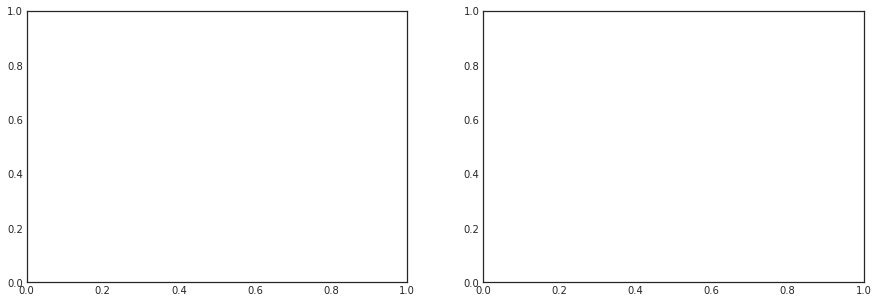

In [28]:
fig, (ax_loss, ax_acc) = plt.subplots(1, 2, figsize=(15,5))
ax_loss.plot(history.epoch, history.history["loss"], label="Train loss")
ax_loss.plot(history.epoch, history.history["val_loss"], label="Validation loss")

In [28]:
model = load_model("./keras 741lb.model",custom_objects={'my_iou_metric': my_iou_metric})

In [13]:
def predict_result(model,x_test,img_size_target): # predict both orginal and reflect x
    x_test_reflect =  np.array([np.fliplr(x) for x in x_test])
    preds_test1 = model.predict(x_test).reshape(-1, img_size_target, img_size_target)
    preds_test2_refect = model.predict(x_test_reflect).reshape(-1, img_size_target, img_size_target)
    preds_test2 = np.array([ np.fliplr(x) for x in preds_test2_refect] )
    preds_avg = (preds_test1 +preds_test2)/2
    return preds_avg

In [46]:
preds_valid = predict_result(model,x_valid,128)
preds_valid2 = np.array([downsample(x) for x in preds_valid])

y_valid2 = np.array([downsample(x) for x in y_valid])

In [32]:
## Scoring for last model
thresholds = np.linspace(0.3, 0.7, 31)
ious = np.array([iou_metric_batch(y_valid2, np.int32(preds_valid2 > threshold)) for threshold in tqdm_notebook(thresholds)])


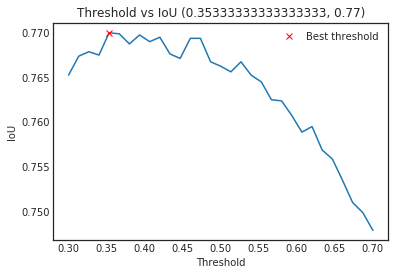

In [33]:
threshold_best_index = np.argmax(ious) 
iou_best = ious[threshold_best_index]
threshold_best = thresholds[threshold_best_index]

plt.plot(thresholds, ious)
plt.plot(threshold_best, iou_best, "xr", label="Best threshold")
plt.xlabel("Threshold")
plt.ylabel("IoU")
plt.title("Threshold vs IoU ({}, {})".format(threshold_best, iou_best))
plt.legend()

In [34]:
"""
used for converting the decoded image to rle mask
Fast compared to previous one
"""
def rle_encode(im):
    '''
    im: numpy array, 1 - mask, 0 - background
    Returns run length as string formated
    '''
    pixels = im.flatten(order = 'F')
    pixels = np.concatenate([[0], pixels, [0]])
    runs = np.where(pixels[1:] != pixels[:-1])[0] + 1
    runs[1::2] -= runs[::2]
    return ' '.join(str(x) for x in runs)

In [47]:
x_test = np.array([upsample(np.array(load_img("./input/test/images/{}.png".format(idx), grayscale=True))) / 255 for idx in tqdm_notebook(test_df.index)]).reshape(-1, img_size_target, img_size_target, 1)

In [48]:
preds_test = predict_result(model,x_test,img_size_target)

In [26]:
#preds_test.dump('7997.pkl')

In [2]:
preds_test2 = np.load("7997.pkl")

In [3]:
preds_test2.shape

(18000, 101, 101)

In [58]:
temp = preds_test2

In [60]:
for i, idx in enumerate(tqdm_notebook(test_df.index.values)):
    temp[i] = downsample(preds_test[i])

In [70]:
preds_avg = ((temp)*0.3 + preds_test2*0.7)

In [ ]:
def filter_image(img):
    if img.sum() < 77:
        return np.zeros(img.shape)
    else:
        return img

In [38]:
import time
t1 = time.time()
pred_dict = {idx: rle_encode(filter_image(preds_avg[i] > threshold_best)) for i, idx in enumerate(tqdm_notebook(test_df.index.values))}
t2 = time.time()

for idx, pred in tqdm(zip(ids, predictions)):



Usedtime = 13.025543212890625 s


In [40]:
sub = pd.DataFrame.from_dict(pred_dict,orient='index')
sub.index.names = ['id']
sub.columns = ['rle_mask']
sub.to_csv('./output/resnet batch norm cycle.csv')